In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisierungsstil setzen
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Daten laden
print("=" * 60)
print("Schritt 1: DATEN LADEN & BEREINIGEN")
print("=" * 60)

file_path = r"C:\Users\Ziran\Workspace2\kundensegmentierung\data\raw\OnlineRetail.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
print(f"\nDaten geladen: {df.shape[0]} Zeilen, {df.shape[1]} Spalten")

print("\n" + "=" * 60)
print("DATENÜBERSICHT")
print("=" * 60)
print(df.info())

print("\n" + "=" * 60)
print("FEHLENDE WERTE")
print("=" * 60)
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Fehlende Werte': missing,
    'Prozent': missing_percent
})
print(missing_df[missing_df['Fehlende Werte'] > 0])

print("\n" + "=" * 60)
print("STATISTISCHE ÜBERBLICKEN")
print("=" * 60)
print(df.describe())

# Daten bereinigen
print("\n" + "=" * 60)
print("BEREINIGUNG DURCHFÜHREN")
print("=" * 60)

print(f"Vor Bereinigung: {df.shape[0]} Zeilen")

# ANALYSE: Überschneidung der fehlenden Werte
print("\nANALYSE DER FEHLENDEN WERTE:")
beide_fehlen = df[df['CustomerID'].isna() & df['Description'].isna()].shape[0]
nur_customerid_fehlt = df[df['CustomerID'].isna() & df['Description'].notna()].shape[0]
nur_description_fehlt = df[df['CustomerID'].notna() & df['Description'].isna()].shape[0]

print(f"BEide fehlen(CustomerID + Description): {beide_fehlen}")
print(f"Nur CustomerID fehlt: {nur_customerid_fehlt}")
print(f"Nur Description fehlt: {nur_description_fehlt}")
print(f"Überschneidung: {beide_fehlen / 1454 * 100:.1f} % der fehlenden Description")

# Fehlende CustomerID entfernen
df = df[df['CustomerID'].notna()]
print(f"Nach Entfernen fehlender CustomerID: {df.shape[0]} Zeilen")

# fehlende Description entfernen
df = df[df['Description'].notna()]
print(f"Nach Entfernung fehlender Description: {df.shape[0]} Zeilen")

# Duplikate entfernen
df = df.drop_duplicates()
print(f"Nach Entfernen von Duplikaten: {df.shape[0]} Zeilen")

# Negative Mengen und Preisen entfernen
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"Nach Entfernen negativer Werte: {df.shape[0]} Zeilen")

# InvoiceDate zu datetime konvertieren
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("InvoiceDate zu datetime konvertiert")

# Zusammenfassung
print("\n" + "=" * 60)
print("BEREINIGTEN DATEN - ZUSAMMENFASSEN")
print("=" * 60)
print(f"Finale Anzahl Zeilen: {df.shape[0]}")
print(f"FInale Anzahl Spalten: {df.shape[1]}")
print(f"\nAnzahl einzigartiger Kunden: {df['CustomerID'].nunique()}")
print(f"Anzahl einzigartiger Produkte: {df['StockCode'].nunique()}")
print(f"Zeitraum: {df['InvoiceDate'].min()} bis {df['InvoiceDate'].max()}")

print("\nSchritt 1 abgeschlossen!")
print("\nBereinigte Daten:")
print(df.head(10))

Schritt 1: DATEN LADEN & BEREINIGEN

Daten geladen: 541909 Zeilen, 8 Spalten

DATENÜBERSICHT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

FEHLENDE WERTE
             Fehlende Werte    Prozent
Description            1454   0.268311
CustomerID           135080  24.926694

STATISTISCHE ÜBERBLICKEN
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   

In [24]:
print("=" * 60)
print("SCHRITT 2: FEATURE ENGINEERING(RFM)")
print("=" * 60)

print("\n" + "=" * 60)
print("Referenzdatum Bestimmen")
print("=" * 60)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Letzter Kauf im Datensatz: {df['InvoiceDate'].max().date()}")
print(f"Referenzdatum: {snapshot_date.date()}")

# RFM-Werte BERECHNEN
print("\n" + "=" * 60)
print("RFM-WERTE BERECHNEN")
print("=" * 60)

# Gesamtbetrag pro Transaktion berechnen
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Pro Kunde Aggregieren
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print("RFM-Features berechnet!")
print(f"\n RFM-Daten für {rfm.shape[0]} Kunden erstellt")
print("\nErste 10 Kunden:")
print(rfm.head(10))

# RFM-STATISTIKEN
print("\n" + "=" * 60)
print("RFM-STATISTIKEN")
print("=" * 60)
print(rfm.describe())

print("\nIntepretation:")
print(f"Durchschnittliche Recency: {rfm['Recency'].mean():.0f} Tage")
print(f" -> Im schnitt kaufte ein Kunde vor {rfm['Recency'].mean():.0f} Tagen zuletzt" )
print(f"\nDurchschnittliche Frequency: {rfm['Frequency'].mean():.1f} Bestellungen")
print(f" -> Ein Kunde macht durchschnittlich {rfm['Frequency'].mean():.1f} Bestellungen")
print(f"\nDurchschnittlihcer Monetary: €{rfm['Monetary'].mean():.2f}")
print(f" -> Ein Kunde gibt durchschnittlich €{rfm['Monetary'].mean():.2f} aus")

SCHRITT 2: FEATURE ENGINEERING(RFM)

Referenzdatum Bestimmen
Letzter Kauf im Datensatz: 2011-12-09
Referenzdatum: 2011-12-10

RFM-WERTE BERECHNEN
RFM-Features berechnet!

 RFM-Daten für 4338 Kunden erstellt

Erste 10 Kunden:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
5     12352.0       36          8   2506.04
6     12353.0      204          1     89.00
7     12354.0      232          1   1079.40
8     12355.0      214          1    459.40
9     12356.0       23          3   2811.43

RFM-STATISTIKEN
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2048.688081
std     1721.808492   100.014169     7.697998    8985.230220
min    12346.000000     1.0000


VISUALISIERUNG DER VERTEILUNGEN


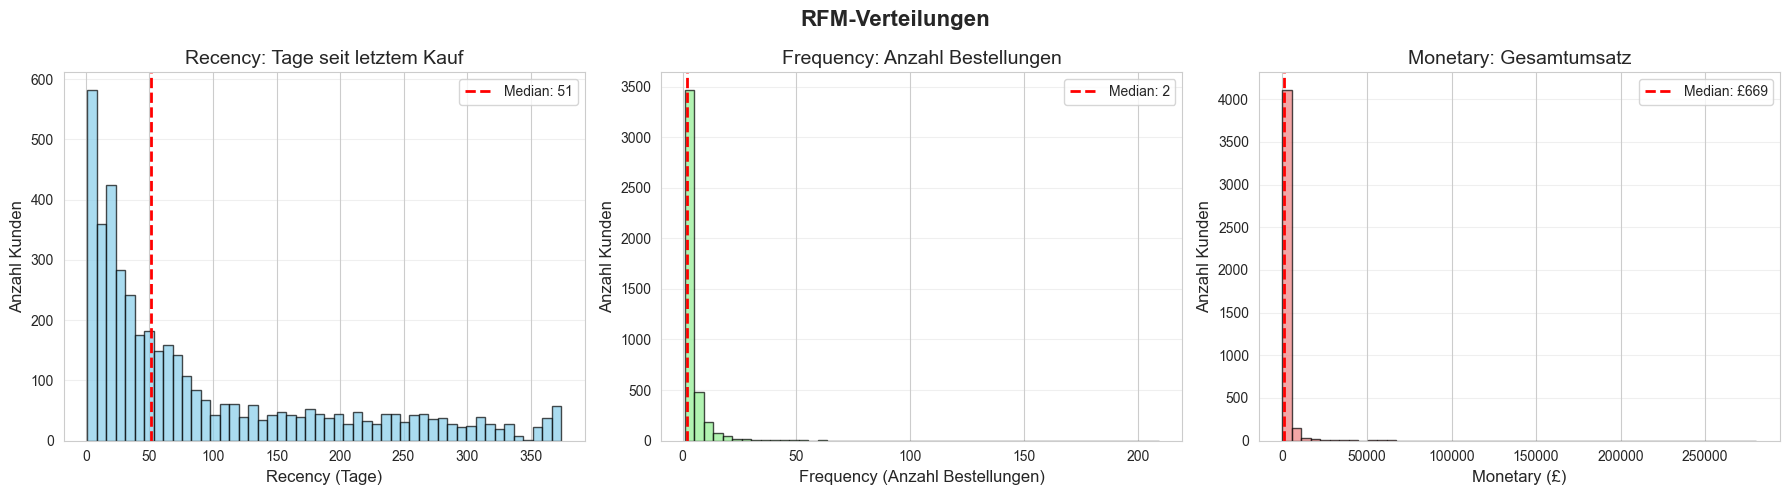


Visualisierung erstellt!

BEOBACHTUNG: Die Verteilungen sind stark rechtsschief!
   -> Viele Kunden mit niedrigen Werten, wenige mit sehr hohen Werten
   -> Das ist typisch für E-Commerce-Daten
   -> Deshalb brauchen wir Transformation in Schritt 4!

SCHRITT 2 ABGESCHLOSSEN!
RFM-DataFrame erstellt: 4338 Kunden, 4 Features

Die Variable 'rfm' ist bereit für Schritt 3 (EDA)!


In [27]:
# RFM-Verteilung visualisierung
print("\n" + "=" * 60)
print("VISUALISIERUNG DER VERTEILUNGEN")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('RFM-Verteilungen', fontsize= 16, fontweight='bold')

# Recency
axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Recency (Tage)', fontsize=12)
axes[0].set_ylabel('Anzahl Kunden', fontsize=12)
axes[0].set_title('Recency: Tage seit letztem Kauf', fontsize=14)
axes[0].axvline(rfm['Recency'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {rfm["Recency"].median():.0f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Frequency
axes[1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Frequency (Anzahl Bestellungen)', fontsize=12)
axes[1].set_ylabel('Anzahl Kunden', fontsize=12)
axes[1].set_title('Frequency: Anzahl Bestellungen', fontsize=14)
axes[1].axvline(rfm['Frequency'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {rfm["Frequency"].median():.0f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Monetary
axes[2].hist(rfm['Monetary'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Monetary (£)', fontsize=12)
axes[2].set_ylabel('Anzahl Kunden', fontsize=12)
axes[2].set_title('Monetary: Gesamtumsatz', fontsize=14)
axes[2].axvline(rfm['Monetary'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: £{rfm["Monetary"].median():.0f}')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualisierung erstellt!")
print("\nBEOBACHTUNG: Die Verteilungen sind stark rechtsschief!")
print("   -> Viele Kunden mit niedrigen Werten, wenige mit sehr hohen Werten")
print("   -> Das ist typisch für E-Commerce-Daten")
print("   -> Deshalb brauchen wir Transformation in Schritt 4!")

# 5. RFM SPEICHERN

print("\n" + "=" * 60)
print("SCHRITT 2 ABGESCHLOSSEN!")
print("=" * 60)
print(f"RFM-DataFrame erstellt: {rfm.shape[0]} Kunden, {rfm.shape[1]} Features")
print("\nDie Variable 'rfm' ist bereit für Schritt 3 (EDA)!")

In [32]:
from scipy import stats

print("=" * 70)
print("EDA (EXPLORATIVE DATENANALYSE)")
print("=" * 70)

print("\n" + "=" * 70)
print("1. DETAILLIERTE RFM-STATISTIKEN")
print("=" * 70)

print("\nDeskriptive Statistiken:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

print("\nZUSÄTZLICHE METRIKEN:")
print("-" * 70)

for col in ['Recency', 'Frequency', 'Monetary']:
    print(f"\n{col}:")
    print(f"  -> Mittelwert:    {rfm[col].mean():.2f}")
    print(f"  -> Median:        {rfm[col].median():.2f}")
    print(f"  -> Std. Abw.:     {rfm[col].std():.2f}")
    print(f"  -> Min - Max:     {rfm[col].min():.2f} - {rfm[col].max():.2f}")
    print(f"  -> Schiefe:       {rfm[col].skew():.2f}")
    print(f"  -> Kurtosis:      {rfm[col].kurtosis():.2f}")

print("\nINTERPRETATION:")
print("  -> Schiefe > 0 = rechtsschief (viele niedrige Werte)")
print("  -> Kurtosis > 0 = schwere Ausreißer vorhanden")

print("\n" + "=" * 70)
print("2. AUSREISSER-ANALYSE (IQR-METHODE)")
print("=" * 70)
print("  IQR-Methode: Werte außerhalb von [Q1 - 1.5*IQR, Q3 + 1.5*IQR]")

outlier_summary = []

for col in ['Recency', 'Frequency', 'Monetary']:
    Q1 = rfm[col].quantile(0.25)
    Q3 = rfm[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = rfm[(rfm[col] < lower_bound) | (rfm[col] > upper_bound)]
    outlier_pct = (len(outliers) / len(rfm)) * 100
    
    print(f"\n{col}:")
    print(f"  -> Q1 (25%):         {Q1:.2f}")
    print(f"  -> Q3 (75%):         {Q3:.2f}")
    print(f"  -> IQR:              {IQR:.2f}")
    print(f"  -> Untere Grenze:    {lower_bound:.2f}")
    print(f"  -> Obere Grenze:     {upper_bound:.2f}")
    print(f"  -> Anzahl Ausreißer: {len(outliers)} ({outlier_pct:.1f}%)")
    
    outlier_summary.append({
        'Feature': col,
        'Anzahl_Ausreißer': len(outliers),
        'Prozent': outlier_pct,
        'Untere_Grenze': lower_bound,
        'Obere_Grenze': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\nZUSAMMENFASSUNG DER AUSREISSER:")
print(outlier_df.to_string(index=False))

print("\n" + "=" * 70)
print("3. KORRELATIONSANALYSE")
print("=" * 70)

correlation = rfm[['Recency', 'Frequency', 'Monetary']].corr()
print("\nKorrelationsmatrix:")
print(correlation)

print("\nINTERPRETATION:")
print("  -> Werte nahe +1: starke positive Korrelation")
print("  -> Werte nahe -1: starke negative Korrelation")
print("  -> Werte nahe 0:  keine Korrelation")

print("\nWICHTIGE ERKENNTNISSE:")
freq_mon_corr = correlation.loc['Frequency', 'Monetary']
rec_freq_corr = correlation.loc['Recency', 'Frequency']
rec_mon_corr = correlation.loc['Recency', 'Monetary']

print(f"Frequency <-> Monetary: {freq_mon_corr:.3f}")
print(f"    -> {'Starke' if abs(freq_mon_corr) > 0.7 else 'Moderate' if abs(freq_mon_corr) > 0.3 else 'Schwache'} Korrelation")
print(f"    -> Wer öfter kauft, gibt auch mehr aus!")
print(f"\n  -> Recency <-> Frequency: {rec_freq_corr:.3f}")
print(f"    -> {'Negative' if rec_freq_corr < 0 else 'Positive'} Korrelation")
print(f"\n  -> Recency <-> Monetary: {rec_mon_corr:.3f}")
print(f"    -> {'Negative' if rec_mon_corr < 0 else 'Positive'} Korrelation")


EDA (EXPLORATIVE DATENANALYSE)

1. DETAILLIERTE RFM-STATISTIKEN

Deskriptive Statistiken:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2048.688081
std     100.014169     7.697998    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   209.000000  280206.020000

ZUSÄTZLICHE METRIKEN:
----------------------------------------------------------------------

Recency:
  -> Mittelwert:    92.54
  -> Median:        51.00
  -> Std. Abw.:     100.01
  -> Min - Max:     1.00 - 374.00
  -> Schiefe:       1.25
  -> Kurtosis:      0.43

Frequency:
  -> Mittelwert:    4.27
  -> Median:        2.00
  -> Std. Abw.:     7.70
  -> Min - Max:     1.00 - 209.00
  -> Schiefe:       12.07
  -> Kurtosis:      249.06

Monetary:
  -> Mittelwert:    2048.69
  -> Me


4. QUARTILE-ANALYSE (Kundenverteilung)

Wie sind die Kunden verteilt?
----------------------------------------------------------------------

Recency:
  -> 0%  (Min):     1.00
  -> 25% (Q1):      18.00
  -> 50% (Median):  51.00
  -> 75% (Q3):      142.00
  -> 100% (Max):    374.00
  -> IQR (Q3-Q1):   124.00
  -> Spanne (Max-Q3): 232.00
    -> 1.9x größer als IQR (zeigt Ausreißer!)

Frequency:
  -> 0%  (Min):     1.00
  -> 25% (Q1):      1.00
  -> 50% (Median):  2.00
  -> 75% (Q3):      5.00
  -> 100% (Max):    209.00
  -> IQR (Q3-Q1):   4.00
  -> Spanne (Max-Q3): 204.00
    -> 51.0x größer als IQR (zeigt Ausreißer!)

Monetary:
  -> 0%  (Min):     3.75
  -> 25% (Q1):      306.48
  -> 50% (Median):  668.57
  -> 75% (Q3):      1660.60
  -> 100% (Max):    280206.02
  -> IQR (Q3-Q1):   1354.11
  -> Spanne (Max-Q3): 278545.42
    -> 205.7x größer als IQR (zeigt Ausreißer!)

5. BOXPLOT-VISUALISIERUNG


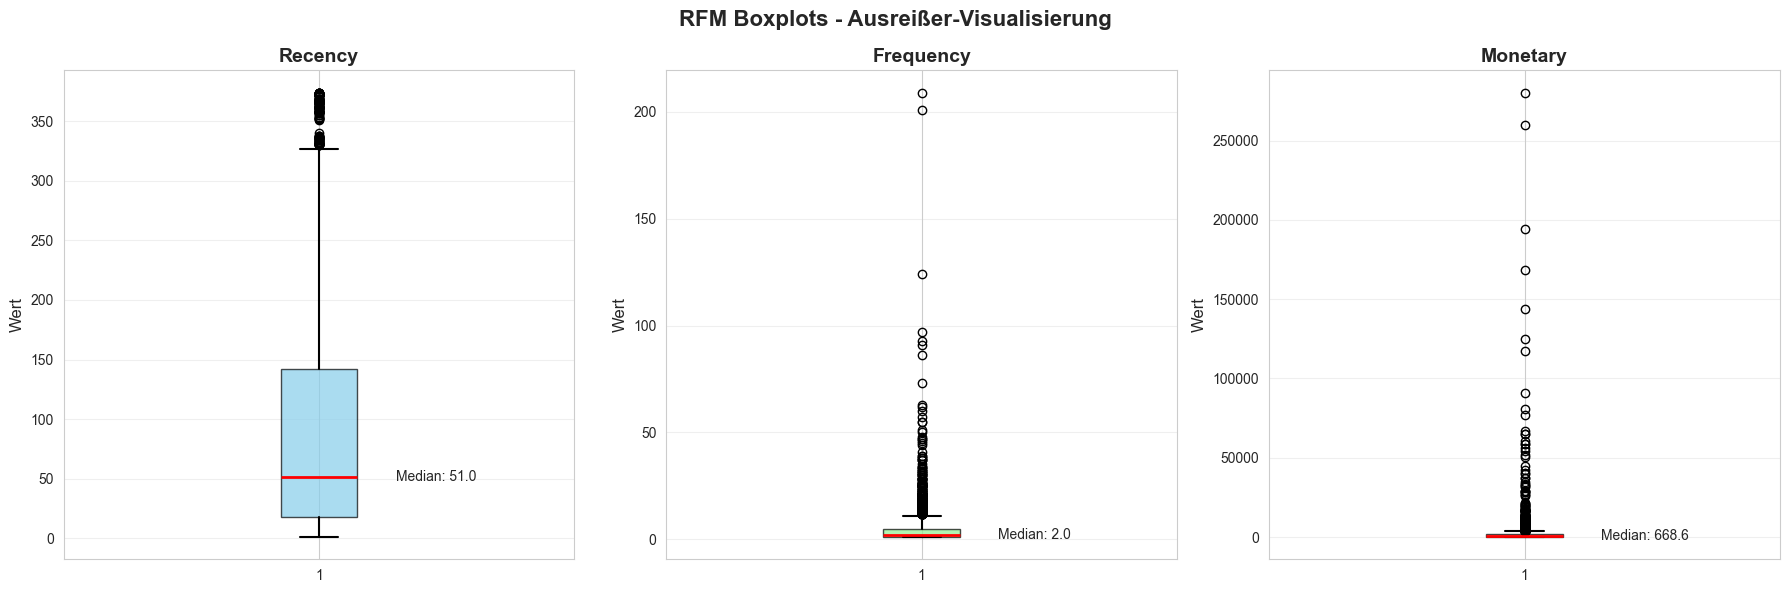


Boxplots erstellt!

BOXPLOT LESEN:
  -> Box = 50% der Daten (Q1 bis Q3)
  -> Rote Linie = Median
  -> Whiskers = 1.5x IQR
  -> Punkte außerhalb = Ausreißer

SCHRITT 3 ABGESCHLOSSEN!

WICHTIGSTE ERKENNTNISSE:
  1. Alle Features sind stark rechtsschief (Schiefe > 0)
  2. Viele Ausreißer vorhanden (besonders bei Frequency & Monetary)
  3. Frequency und Monetary korrelieren positiv
  4. Die Verteilungen sind nicht normal ->Transformation nötig!

NÄCHSTER SCHRITT:
  -> Schritt 4: Log-Transformation & Skalierung
  -> Damit DBSCAN besser funktioniert!



In [35]:
# 4. QUARTILE-ANALYSE (Kundenverteilung)
print("\n" + "=" * 70)
print("4. QUARTILE-ANALYSE (Kundenverteilung)")
print("=" * 70)

print("\nWie sind die Kunden verteilt?")
print("-" * 70)

for col in ['Recency', 'Frequency', 'Monetary']:
    print(f"\n{col}:")
    quartiles = rfm[col].quantile([0, 0.25, 0.5, 0.75, 1.0])
    
    print(f"  -> 0%  (Min):     {quartiles[0.00]:.2f}")
    print(f"  -> 25% (Q1):      {quartiles[0.25]:.2f}")
    print(f"  -> 50% (Median):  {quartiles[0.50]:.2f}")
    print(f"  -> 75% (Q3):      {quartiles[0.75]:.2f}")
    print(f"  -> 100% (Max):    {quartiles[1.00]:.2f}")
    
    # Spanne zwischen Q3 und Max
    spread = quartiles[1.00] - quartiles[0.75]
    iqr = quartiles[0.75] - quartiles[0.25]
    
    print(f"  -> IQR (Q3-Q1):   {iqr:.2f}")
    print(f"  -> Spanne (Max-Q3): {spread:.2f}")
    print(f"    -> {spread/iqr:.1f}x größer als IQR (zeigt Ausreißer!)")

# 5. VISUALISIERUNG: BOXPLOTS

print("\n" + "=" * 70)
print("5. BOXPLOT-VISUALISIERUNG")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('RFM Boxplots - Ausreißer-Visualisierung', fontsize=16, fontweight='bold')

features = ['Recency', 'Frequency', 'Monetary']
colors = ['skyblue', 'lightgreen', 'lightcoral']

for idx, (col, color) in enumerate(zip(features, colors)):
    # Boxplot
    bp = axes[idx].boxplot(rfm[col], vert=True, patch_artist=True,
                            boxprops=dict(facecolor=color, alpha=0.7),
                            medianprops=dict(color='red', linewidth=2),
                            whiskerprops=dict(linewidth=1.5),
                            capprops=dict(linewidth=1.5))
    
    axes[idx].set_ylabel('Wert', fontsize=12)
    axes[idx].set_title(f'{col}', fontsize=14, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Statistiken anzeigen
    median_val = rfm[col].median()
    q1 = rfm[col].quantile(0.25)
    q3 = rfm[col].quantile(0.75)
    
    axes[idx].text(1.15, median_val, f'Median: {median_val:.1f}', 
                   fontsize=10, va='center')

plt.tight_layout()
plt.show()

print("\nBoxplots erstellt!")
print("\nBOXPLOT LESEN:")
print("  -> Box = 50% der Daten (Q1 bis Q3)")
print("  -> Rote Linie = Median")
print("  -> Whiskers = 1.5x IQR")
print("  -> Punkte außerhalb = Ausreißer")

# 6. ZUSAMMENFASSUNG

print("\n" + "=" * 70)
print("SCHRITT 3 ABGESCHLOSSEN!")
print("=" * 70)

print("\nWICHTIGSTE ERKENNTNISSE:")
print("  1. Alle Features sind stark rechtsschief (Schiefe > 0)")
print("  2. Viele Ausreißer vorhanden (besonders bei Frequency & Monetary)")
print("  3. Frequency und Monetary korrelieren positiv")
print("  4. Die Verteilungen sind nicht normal ->Transformation nötig!")

print("\nNÄCHSTER SCHRITT:")
print("  -> Schritt 4: Log-Transformation & Skalierung")
print("  -> Damit DBSCAN besser funktioniert!")

print("\n" + "=" * 70)

SCHRITT 4: TRANSFORMATION & SKALIERUNG
  1. Log-Transformation → macht Verteilung symmetrischer
  2. StandardScaler → macht alle Features vergleichbar (Mittelwert=0, Std=1)

2. LOG-TRANSFORMATION ANWENDEN

Log-Transformation: log(x + 1)
  -> +1 damit log(0) nicht zu -∞ wird
  -> Komprimiert große Werte, lässt kleine Werte relativ unverändert

Log-Transformation abgeschlossen!

VERGLEICH: Original vs. Log-transformiert
----------------------------------------------------------------------

Recency:
  Original:
    - Mittelwert: 92.54
    - Std. Abw.:  100.01
    - Schiefe:    1.25
  Nach Log-Transformation:
    - Mittelwert: 3.83
    - Std. Abw.:  1.34
    - Schiefe:    -0.38
    -> Schiefe reduziert um 130.4%

Frequency:
  Original:
    - Mittelwert: 4.27
    - Std. Abw.:  7.70
    - Schiefe:    12.07
  Nach Log-Transformation:
    - Mittelwert: 1.35
    - Std. Abw.:  0.68
    - Schiefe:    1.21
    -> Schiefe reduziert um 90.0%

Monetary:
  Original:
    - Mittelwert: 2048.69
    - St

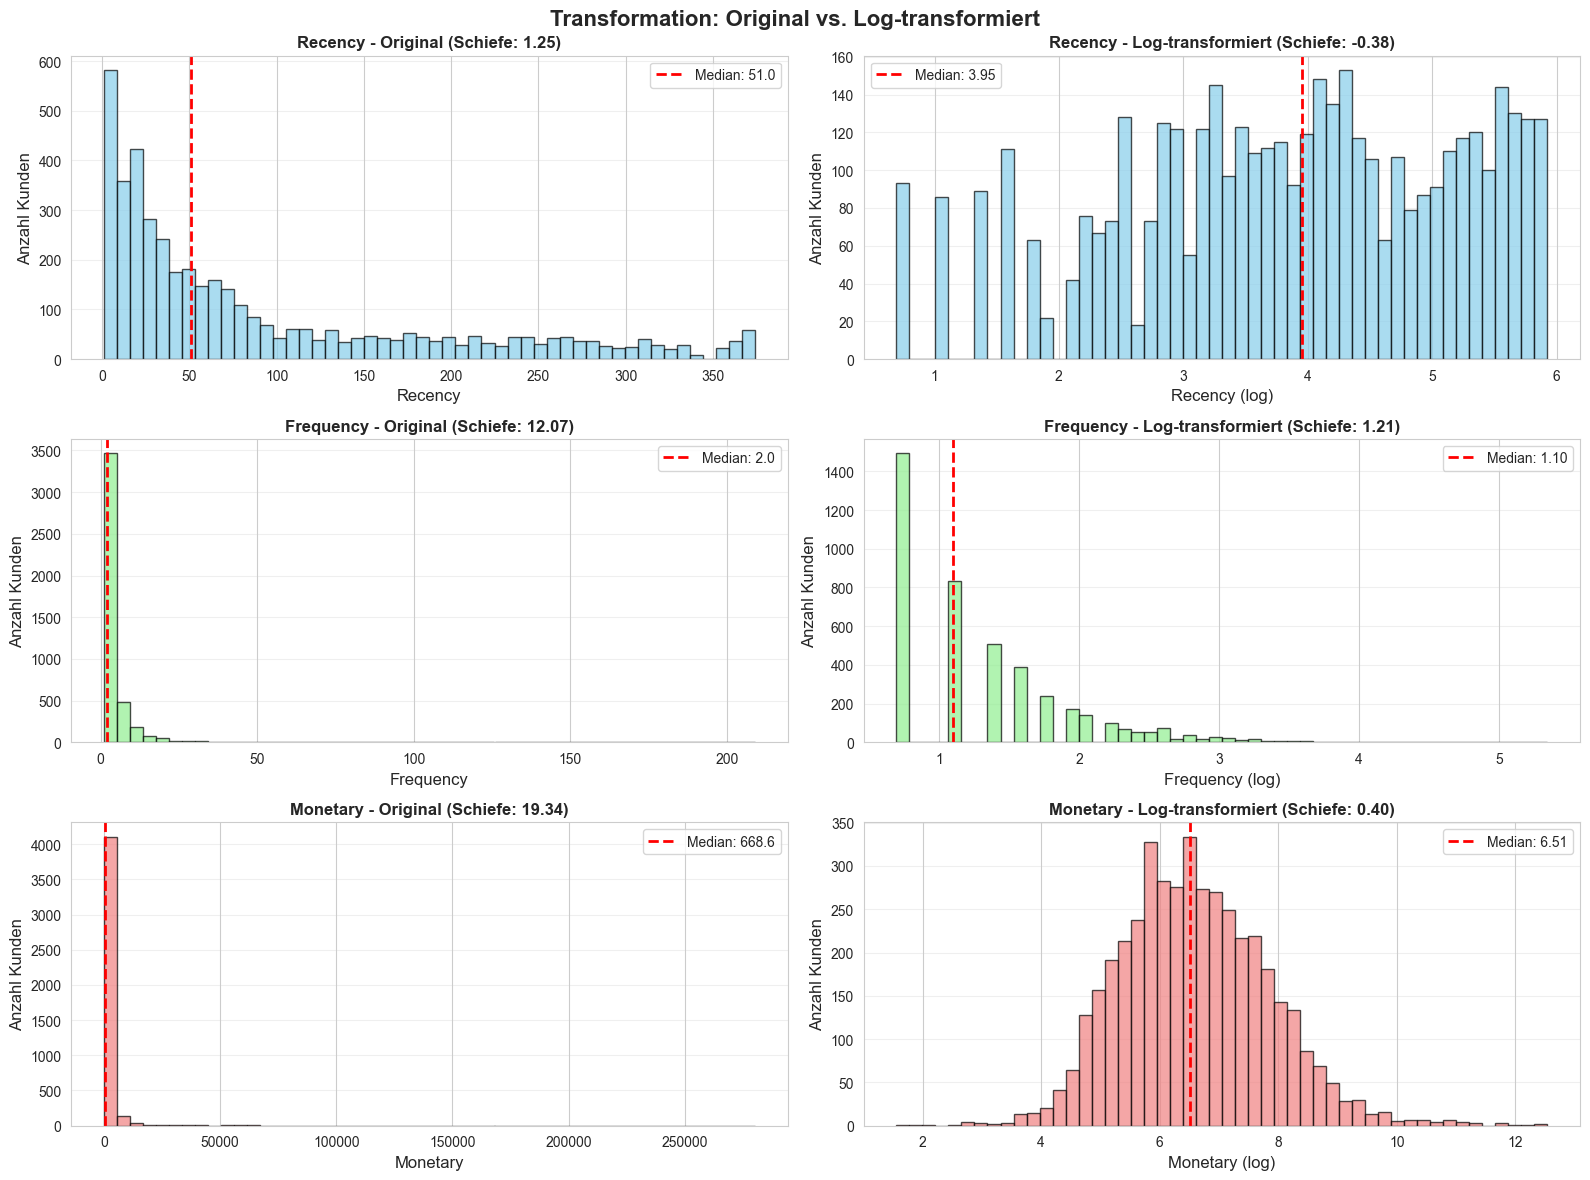


Visualisierung erstellt!

BEOBACHTUNG:
  -> Die Verteilungen sind jetzt viel symmetrischer!
  -> Die Schiefe ist deutlich reduziert
  -> Ausreißer haben weniger Einfluss

4. STANDARDISIERUNG MIT STANDARDSCALER

StandardScaler:
  -> Zentriert Daten: Mittelwert = 0
  -> Normalisiert Streuung: Standardabweichung = 1
  -> Formel: z = (x - μ) / σ
  -> WICHTIG: Alle Features haben danach die gleiche Skala!

Standardisierung abgeschlossen!

VERGLEICH: Log vs. Skaliert
----------------------------------------------------------------------

Recency:
  Nach Log:
    - Mittelwert: 3.83
    - Std. Abw.:  1.34
    - Min - Max:  0.69 - 5.93
  Nach Skalierung:
    - Mittelwert: -0.000000 (≈ 0)
    - Std. Abw.:  1.000115 (≈ 1)
    - Min - Max:  -2.34 - 1.56

Frequency:
  Nach Log:
    - Mittelwert: 1.35
    - Std. Abw.:  0.68
    - Min - Max:  0.69 - 5.35
  Nach Skalierung:
    - Mittelwert: -0.000000 (≈ 0)
    - Std. Abw.:  1.000115 (≈ 1)
    - Min - Max:  -0.96 - 5.86

Monetary:
  Nach Log:
    - M

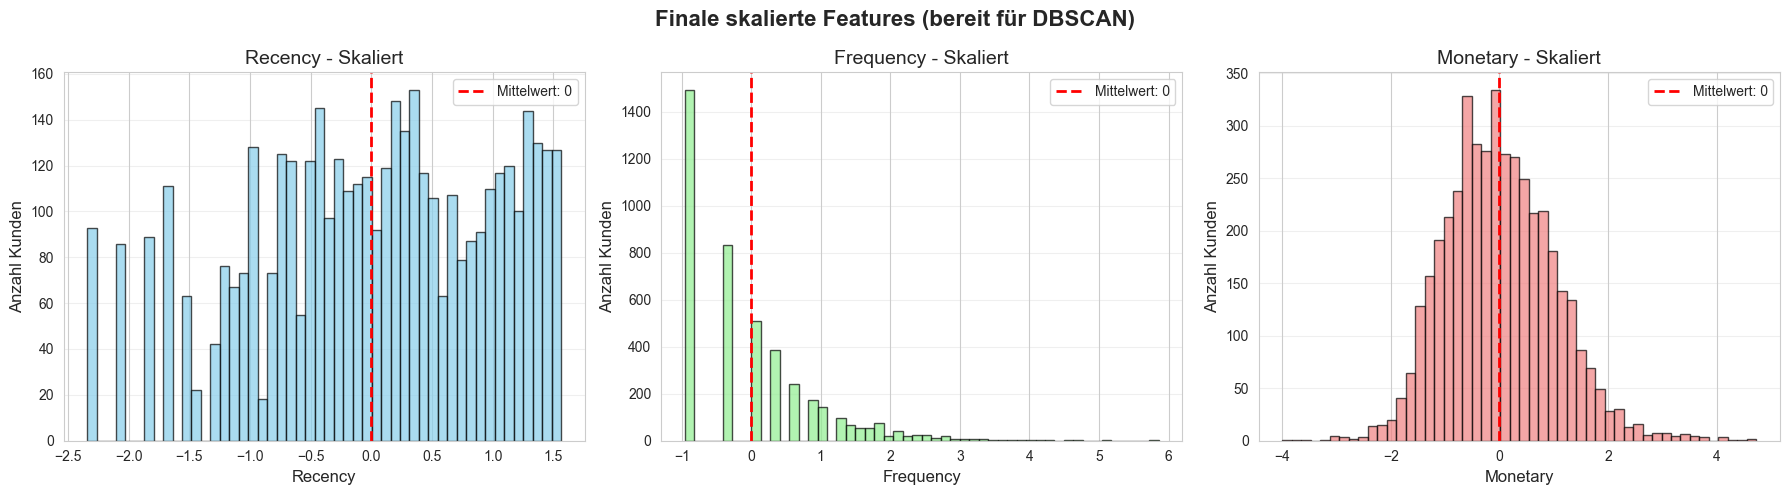


Visualisierung erstellt!

SCHRITT 4 ABGESCHLOSSEN!

WAS HABEN WIR ERREICHT?
  1.  Log-Transformation → symmetrischere Verteilungen
  2.  Standardisierung → alle Features auf gleicher Skala
  3.  Ausreißer haben weniger Einfluss
  4.  Daten sind bereit für DBSCAN!

FINALE DATEN:
  -> Shape: (4338, 4)
  -> Features: ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
  -> Kunden: 4338

Erste 10 Zeilen der skalierten Daten:
   Recency_scaled  Frequency_scaled  Monetary_scaled  CustomerID
0        1.461993         -0.955214         3.707716     12346.0
1       -2.038734          1.074425         1.414903     12347.0
2        0.373104          0.386304         0.720024     12348.0
3       -0.623086         -0.955214         0.702287     12349.0
4        1.424558         -0.955214        -0.614514     12350.0
5       -0.164029          1.246868         0.984108     12352.0
6        1.113550         -0.955214        -1.659989     12353.0
7        1.209086         -0.955214         0.31

In [41]:
from sklearn.preprocessing import StandardScaler

print("=" * 70)
print("SCHRITT 4: TRANSFORMATION & SKALIERUNG")
print("=" * 70)

print("  1. Log-Transformation → macht Verteilung symmetrischer")
print("  2. StandardScaler → macht alle Features vergleichbar (Mittelwert=0, Std=1)")

# 2. LOG-TRANSFORMATION

print("\n" + "=" * 70)
print("2. LOG-TRANSFORMATION ANWENDEN")
print("=" * 70)

print("\nLog-Transformation: log(x + 1)")
print("  -> +1 damit log(0) nicht zu -∞ wird")
print("  -> Komprimiert große Werte, lässt kleine Werte relativ unverändert")

# Log-Transformation anwenden
rfm_log = rfm.copy()
rfm_log['Recency_log'] = np.log1p(rfm['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm['Monetary'])

print("\nLog-Transformation abgeschlossen!")
print("\nVERGLEICH: Original vs. Log-transformiert")
print("-" * 70)

for col in ['Recency', 'Frequency', 'Monetary']:
    col_log = f"{col}_log"
    
    print(f"\n{col}:")
    print(f"  Original:")
    print(f"    - Mittelwert: {rfm[col].mean():.2f}")
    print(f"    - Std. Abw.:  {rfm[col].std():.2f}")
    print(f"    - Schiefe:    {rfm[col].skew():.2f}")
    
    print(f"  Nach Log-Transformation:")
    print(f"    - Mittelwert: {rfm_log[col_log].mean():.2f}")
    print(f"    - Std. Abw.:  {rfm_log[col_log].std():.2f}")
    print(f"    - Schiefe:    {rfm_log[col_log].skew():.2f}")
    print(f"    -> Schiefe reduziert um {((rfm[col].skew() - rfm_log[col_log].skew()) / rfm[col].skew() * 100):.1f}%")

# 3. VISUALISIERUNG: VORHER vs. NACHHER

print("\n" + "=" * 70)
print("3. VISUALISIERUNG: VORHER vs. NACHHER")
print("=" * 70)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Transformation: Original vs. Log-transformiert', 
             fontsize=16, fontweight='bold')

features = ['Recency', 'Frequency', 'Monetary']
colors = ['skyblue', 'lightgreen', 'lightcoral']

for idx, (col, color) in enumerate(zip(features, colors)):
    col_log = f"{col}_log"
    
    # Original (links)
    axes[idx, 0].hist(rfm[col], bins=50, color=color, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_xlabel(col, fontsize=12)
    axes[idx, 0].set_ylabel('Anzahl Kunden', fontsize=12)
    axes[idx, 0].set_title(f'{col} - Original (Schiefe: {rfm[col].skew():.2f})', 
                           fontsize=12, fontweight='bold')
    axes[idx, 0].axvline(rfm[col].median(), color='red', linestyle='--', 
                         linewidth=2, label=f'Median: {rfm[col].median():.1f}')
    axes[idx, 0].legend()
    axes[idx, 0].grid(axis='y', alpha=0.3)
    
    # Log-transformiert (rechts)
    axes[idx, 1].hist(rfm_log[col_log], bins=50, color=color, edgecolor='black', alpha=0.7)
    axes[idx, 1].set_xlabel(f'{col} (log)', fontsize=12)
    axes[idx, 1].set_ylabel('Anzahl Kunden', fontsize=12)
    axes[idx, 1].set_title(f'{col} - Log-transformiert (Schiefe: {rfm_log[col_log].skew():.2f})', 
                           fontsize=12, fontweight='bold')
    axes[idx, 1].axvline(rfm_log[col_log].median(), color='red', linestyle='--', 
                         linewidth=2, label=f'Median: {rfm_log[col_log].median():.2f}')
    axes[idx, 1].legend()
    axes[idx, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualisierung erstellt!")
print("\nBEOBACHTUNG:")
print("  -> Die Verteilungen sind jetzt viel symmetrischer!")
print("  -> Die Schiefe ist deutlich reduziert")
print("  -> Ausreißer haben weniger Einfluss")


# 4. STANDARDISIERUNG (SCALING)

print("\n" + "=" * 70)
print("4. STANDARDISIERUNG MIT STANDARDSCALER")
print("=" * 70)

print("\nStandardScaler:")
print("  -> Zentriert Daten: Mittelwert = 0")
print("  -> Normalisiert Streuung: Standardabweichung = 1")
print("  -> Formel: z = (x - μ) / σ")
print("  -> WICHTIG: Alle Features haben danach die gleiche Skala!")

# Nur die log-transformierten Features auswählen
features_to_scale = ['Recency_log', 'Frequency_log', 'Monetary_log']
X = rfm_log[features_to_scale].values

# StandardScaler anwenden
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Als DataFrame speichern
rfm_scaled = pd.DataFrame(
    X_scaled, 
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'],
    index=rfm.index
)

# CustomerID hinzufügen für spätere Referenz
rfm_scaled['CustomerID'] = rfm['CustomerID'].values

print("\nStandardisierung abgeschlossen!")
print("\nVERGLEICH: Log vs. Skaliert")
print("-" * 70)

for i, col in enumerate(features_to_scale):
    scaled_col = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'][i]
    
    print(f"\n{col.replace('_log', '')}:")
    print(f"  Nach Log:")
    print(f"    - Mittelwert: {rfm_log[col].mean():.2f}")
    print(f"    - Std. Abw.:  {rfm_log[col].std():.2f}")
    print(f"    - Min - Max:  {rfm_log[col].min():.2f} - {rfm_log[col].max():.2f}")
    
    print(f"  Nach Skalierung:")
    print(f"    - Mittelwert: {rfm_scaled[scaled_col].mean():.6f} (≈ 0)")
    print(f"    - Std. Abw.:  {rfm_scaled[scaled_col].std():.6f} (≈ 1)")
    print(f"    - Min - Max:  {rfm_scaled[scaled_col].min():.2f} - {rfm_scaled[scaled_col].max():.2f}")


# 5. FINALE VISUALISIERUNG: SKALIERTE DATEN

print("\n" + "=" * 70)
print("5. FINALE VISUALISIERUNG: SKALIERTE DATEN")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Finale skalierte Features (bereit für DBSCAN)', 
             fontsize=16, fontweight='bold')

scaled_features = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
colors = ['skyblue', 'lightgreen', 'lightcoral']

for idx, (col, color) in enumerate(zip(scaled_features, colors)):
    axes[idx].hist(rfm_scaled[col], bins=50, color=color, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col.replace('_scaled', ''), fontsize=12)
    axes[idx].set_ylabel('Anzahl Kunden', fontsize=12)
    axes[idx].set_title(f'{col.replace("_scaled", "")} - Skaliert', fontsize=14)
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Mittelwert: 0')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualisierung erstellt!")


# 6. ZUSAMMENFASSUNG & SPEICHERN

print("\n" + "=" * 70)
print("SCHRITT 4 ABGESCHLOSSEN!")
print("=" * 70)

print("\nWAS HABEN WIR ERREICHT?")
print("  1.  Log-Transformation -> symmetrischere Verteilungen")
print("  2.  Standardisierung -> alle Features auf gleicher Skala")
print("  3.  Ausreißer haben weniger Einfluss")
print("  4.  Daten sind bereit für DBSCAN!")

print("\nFINALE DATEN:")
print(f"  -> Shape: {rfm_scaled.shape}")
print(f"  -> Features: {scaled_features}")
print(f"  -> Kunden: {len(rfm_scaled)}")

print("\nErste 10 Zeilen der skalierten Daten:")
print(rfm_scaled.head(10))

In [39]:
print("\nNÄCHSTER SCHRITT:")
print("  -> PHASE 2: DBSCAN CLUSTERING!")
print("  -> Wir finden die optimalen Parameter (eps, min_samples)")
print("  -> Dann clustern wir die Kunden!")

print("\n" + "=" * 70)



NÄCHSTER SCHRITT:
  -> PHASE 2: DBSCAN CLUSTERING!
  -> Wir finden die optimalen Parameter (eps, min_samples)
  -> Dann clustern wir die Kunden!



PHASE 2: DBSCAN CLUSTERING

ZWEI WICHTIGE PARAMETER:
1. eps (epsilon): Wie nah müssen Punkte beieinander sein?
   -> Der 'Radius' um jeden Punkt
2. min_samples:Wie viele Nachbarn braucht ein Punkt mindestens?
   -> Mindestanzahl für eine 'dichte Region'

 HERAUSFORDERUNG:
-> eps und min_samples müssen gut gewählt sein!

1. OPTIMALES EPS FINDEN (K-DISTANCE GRAPH)

 METHODE: K-Distance Graph
  - Für jeden Punkt: Distanz zum k-nächsten Nachbarn berechnen
  - k = min_samples (üblicherweise 2 * Dimension = 2 * 3 = 6)
  - sortierung und plotten
  - 'Ellbogen' im Graph = optimales eps!

 min_samples = 6


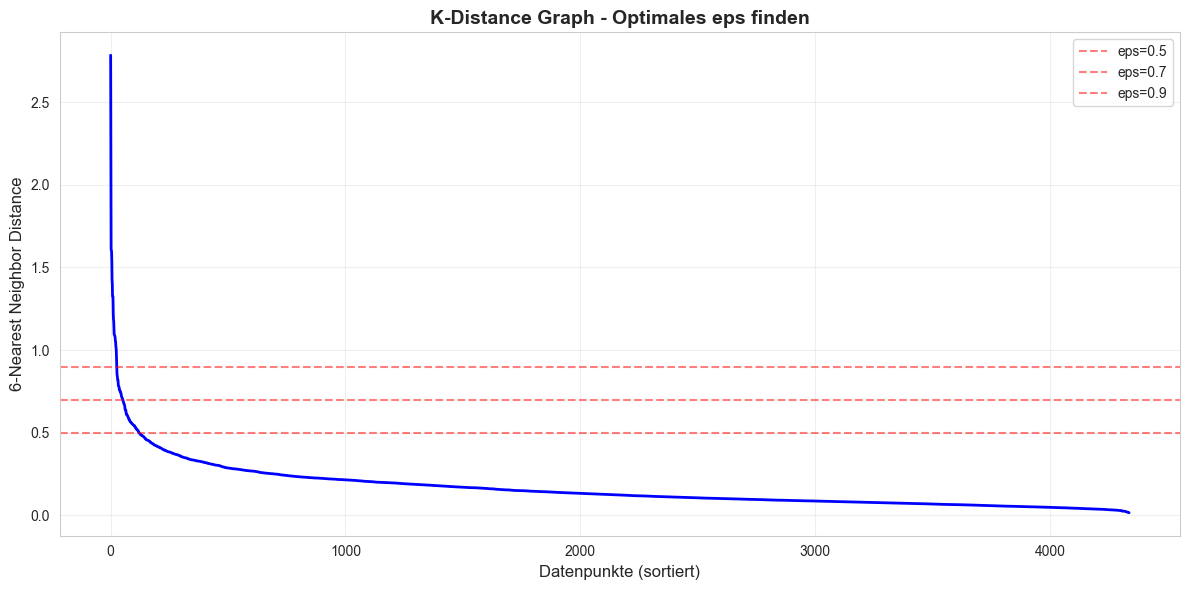


 STATISTISCHE HILFE FÜR EPS:
  -> 90. Perzentil: 0.309
  -> 95. Perzentil: 0.404
  -> 97. Perzentil: 0.488
  -> 99. Perzentil: 0.741

Median: 0.123
Mittelwert: 0.165

EMPFEHLUNG:
 -> Starte mit eps 0.40(95.Perzentil)


In [53]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("=" * 70)
print("PHASE 2: DBSCAN CLUSTERING")
print("=" * 70)
print("\nZWEI WICHTIGE PARAMETER:")
print("1. eps (epsilon): Wie nah müssen Punkte beieinander sein?")
print("   -> Der 'Radius' um jeden Punkt")
print("2. min_samples:Wie viele Nachbarn braucht ein Punkt mindestens?")
print("   -> Mindestanzahl für eine 'dichte Region'")
print("\n HERAUSFORDERUNG:")
print("-> eps und min_samples müssen gut gewählt sein!")


# 1. Optimales eps finden
print("\n" + "=" * 70)
print("1. OPTIMALES EPS FINDEN (K-DISTANCE GRAPH)")
print("=" * 70)

print("\n METHODE: K-Distance Graph")
print("  - Für jeden Punkt: Distanz zum k-nächsten Nachbarn berechnen")
print("  - k = min_samples (üblicherweise 2 * Dimension = 2 * 3 = 6)")
print("  - sortierung und plotten")
print("  - 'Ellbogen' im Graph = optimales eps!")

# Features für Clustering vorbereiten
X = rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']].values
min_samples = 6
print(f"\n min_samples = {min_samples}")

# k-Distanzen berechnen
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit =neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Distanz zum k-nächsten Nachbarn
k_distances = distances[:, -1]
k_distances_sorted = np.sort(k_distances)[::-1]

# K-Distance Graph plotten
plt.figure(figsize=(12, 6))
plt.plot(k_distances_sorted, linewidth=2, color='blue')
plt.xlabel('Datenpunkte (sortiert)', fontsize=12)
plt.ylabel(f'{min_samples}-Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph - Optimales eps finden', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Ellbogen-Bereich makieren
elbow_candidates=[0.5, 0.7, 0.9]
for eps_val in elbow_candidates:
    plt.axhline(y=eps_val, color='red', linestyle='--', alpha=0.5, label=f'eps={eps_val}')
plt.legend()
plt.tight_layout()
plt.show()

# Statistische Analyse für eps
print("\n STATISTISCHE HILFE FÜR EPS:")
percentiles = [90, 95, 97, 99]
for p in percentiles:
    val = np.percentile(k_distances, p)
    print(f"  -> {p}. Perzentil: {val:.3f}")
print(f"\nMedian: {np.median(k_distances):.3f}")
print(f"Mittelwert: {np.mean(k_distances):.3f}")
print("\nEMPFEHLUNG:")
suggested_eps = np.percentile(k_distances, 95)
print(f" -> Starte mit eps {suggested_eps:.2f}(95.Perzentil)")

In [55]:
print("\n" + "=" * 70)
print("2. DBSCAN MIT VERSCHIEDENEN PARAMETERN TESTEN")
print("=" * 70)

print("\nPARAMETER-GRID:")
eps_values = [0.5, 0.7, 0.9, 1.1]
min_samples_values = [5, 6, 7, 8]

results = []

for eps in eps_values:
    for min_samp in min_samples_values:
        # DBSCAN durchführen
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X)
        
        # Ergebnisse analysieren
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = (n_noise / len(labels)) * 100
        
        # Silhouette Score (nur wenn mindestens 2 Cluster)
        if n_clusters >= 2:
            sil_score = silhouette_score(X, labels)
        else:
            sil_score = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': sil_score
        })

# Ergebnisse als DataFrame
results_df = pd.DataFrame(results)

print("\nTESTERGEBNISSE:")
print(results_df.to_string(index=False))

print("\nWIE MAN DIE ERGEBNISSE INTERPRETIERT:")
print("  - n_clusters: Anzahl gefundener Cluster")
print("    -> Zu wenig (<3): Parameter zu streng")
print("    -> Zu viel (>10): Parameter zu locker")
print("    -> Optimal: 3-6 Cluster für Kundensegmentierung")
print("\n  - noise_pct: Prozent Ausreißer")
print("    -> Optimal: 5-15% (zu viel = zu streng, zu wenig = zu locker)")
print("\n  - silhouette: Cluster-Qualität (-1 bis 1)")
print("    -> Je höher, desto besser getrennt sind die Cluster")
print("    -> >0.3 = akzeptabel, >0.5 = gut")

# Beste Kombination finden
print("\nTOP 3 PARAMETER-KOMBINATIONEN:")
# Filter: mindestens 2 Cluster, max 30% Noise
valid_results = results_df[
    (results_df['n_clusters'] >= 2) & 
    (results_df['noise_pct'] <= 30)
].sort_values('silhouette', ascending=False).head(3)

print(valid_results.to_string(index=False))

# Beste Kombination
if len(valid_results) > 0:
    best = valid_results.iloc[0]
    best_eps = best['eps']
    best_min_samples = int(best['min_samples'])
    
    print(f"\nEMPFOHLENE PARAMETER:")
    print(f"  - eps = {best_eps}")
    print(f"  - min_samples = {best_min_samples}")
    print(f"  -> {int(best['n_clusters'])} Cluster, {best['noise_pct']:.1f}% Noise")
    print(f"  -> Silhouette Score: {best['silhouette']:.3f}")
else:
    print("\nKeine gute Kombination gefunden - Parameter anpassen!")
    best_eps = 0.7
    best_min_samples = 6

# 4. FINALES DBSCAN-CLUSTERING

print("\n" + "=" * 70)
print("4. FINALES DBSCAN-CLUSTERING")
print("=" * 70)

print(f"\nClustern mit eps={best_eps}, min_samples={best_min_samples}")

# DBSCAN mit besten Parametern
final_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
rfm_scaled['Cluster'] = final_dbscan.fit_predict(X)

# Ergebnisse
n_clusters_final = len(set(rfm_scaled['Cluster'])) - (1 if -1 in rfm_scaled['Cluster'].values else 0)
n_noise_final = (rfm_scaled['Cluster'] == -1).sum()

print(f"\nClustering abgeschlossen!")
print(f"  - Anzahl Cluster: {n_clusters_final}")
print(f"  - Anzahl Noise: {n_noise_final} ({n_noise_final/len(rfm_scaled)*100:.1f}%)")

print("\nCLUSTER-VERTEILUNG:")
cluster_counts = rfm_scaled['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    if cluster == -1:
        print(f"  • Noise: {count} Kunden ({count/len(rfm_scaled)*100:.1f}%)")
    else:
        print(f"  • Cluster {cluster}: {count} Kunden ({count/len(rfm_scaled)*100:.1f}%)")

print("\n" + "=" * 70)
print("PHASE 2 ABGESCHLOSSEN!")
print("=" * 70)

print("\nNÄCHSTER SCHRITT:")
print("  -> Cluster analysieren und interpretieren")
print("  -> Visualisierungen erstellen")
print("  -> Business-Insights ableiten!")

print("\nErste 10 Zeilen mit Cluster-Labels:")
print(rfm_scaled.head(10))


2. DBSCAN MIT VERSCHIEDENEN PARAMETERN TESTEN

PARAMETER-GRID:

TESTERGEBNISSE:
 eps  min_samples  n_clusters  n_noise  noise_pct  silhouette
 0.5            5           2       62   1.429230    0.266158
 0.5            6           3       64   1.475334    0.206650
 0.5            7           2       70   1.613647    0.265005
 0.5            8           2       71   1.636699    0.265411
 0.7            5           2       26   0.599355    0.532165
 0.7            6           1       32   0.737667   -1.000000
 0.7            7           1       36   0.829876   -1.000000
 0.7            8           1       37   0.852928   -1.000000
 0.9            5           1       13   0.299677   -1.000000
 0.9            6           1       15   0.345781   -1.000000
 0.9            7           1       15   0.345781   -1.000000
 0.9            8           1       15   0.345781   -1.000000
 1.1            5           1        7   0.161365   -1.000000
 1.1            6           1        7   0.161365  

In [57]:
print("=" * 70)
print("PARAMETER NEU TESTEN - KLEINERE EPS-WERTE")
print("=" * 70)

# Neue eps-Werte: näher am 95. Perzentil (0.40)
eps_values_new = [0.3, 0.35, 0.4, 0.45, 0.5]
min_samples_values_new = [4, 5, 6]

results_new = []

for eps in eps_values_new:
    for min_samp in min_samples_values_new:
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = (n_noise / len(labels)) * 100
        
        if n_clusters >= 2:
            sil_score = silhouette_score(X, labels)
        else:
            sil_score = -1
        
        # Cluster-Größen
        cluster_sizes = []
        for i in range(n_clusters):
            size = (labels == i).sum()
            cluster_sizes.append(size)
        
        # Kleinster und größter Cluster
        if len(cluster_sizes) > 0:
            min_cluster_size = min(cluster_sizes)
            max_cluster_size = max(cluster_sizes)
            balance = min_cluster_size / max_cluster_size if max_cluster_size > 0 else 0
        else:
            min_cluster_size = 0
            max_cluster_size = 0
            balance = 0
        
        results_new.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': sil_score,
            'min_cluster': min_cluster_size,
            'max_cluster': max_cluster_size,
            'balance': balance
        })

results_new_df = pd.DataFrame(results_new)

print("\nNEUE TESTERGEBNISSE:")
print(results_new_df.to_string(index=False))

print("\nSUCHE NACH BESSERER SEGMENTIERUNG:")
print("  -> Ziel: 3-6 Cluster")
print("  -> Noise: 5-15%")
print("  -> Balance: Cluster sollten nicht zu unterschiedlich sein")

# Beste Kombinationen finden (3-6 Cluster, akzeptable Noise)
valid_new = results_new_df[
    (results_new_df['n_clusters'] >= 3) & 
    (results_new_df['n_clusters'] <= 6) &
    (results_new_df['noise_pct'] <= 20) &
    (results_new_df['balance'] >= 0.1)  # Mindestens 10% Balance
].sort_values('silhouette', ascending=False)

if len(valid_new) > 0:
    print("\nTOP KANDIDATEN:")
    print(valid_new.head(5).to_string(index=False))
    
    best_new = valid_new.iloc[0]
    best_eps_new = best_new['eps']
    best_min_samples_new = int(best_new['min_samples'])
    
    print(f"\nNEUE EMPFOHLENE PARAMETER:")
    print(f"  -> eps = {best_eps_new}")
    print(f"  -> min_samples = {best_min_samples_new}")
    print(f"  -> {int(best_new['n_clusters'])} Cluster")
    print(f"  -> {best_new['noise_pct']:.1f}% Noise")
    print(f"  -> Silhouette: {best_new['silhouette']:.3f}")
    print(f"  -> Kleinster Cluster: {int(best_new['min_cluster'])} Kunden")
    print(f"  -> Größter Cluster: {int(best_new['max_cluster'])} Kunden")
    print(f"  -> Balance: {best_new['balance']:.2%}")
    
    # Finales Clustering mit neuen Parametern
    print(f"\nFinales Clustering mit eps={best_eps_new}, min_samples={best_min_samples_new}")
    
    final_dbscan_new = DBSCAN(eps=best_eps_new, min_samples=best_min_samples_new)
    rfm_scaled['Cluster'] = final_dbscan_new.fit_predict(X)
    
    print("\nNEUE CLUSTER-VERTEILUNG:")
    cluster_counts = rfm_scaled['Cluster'].value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        if cluster == -1:
            print(f"  - Noise: {count} Kunden ({count/len(rfm_scaled)*100:.1f}%)")
        else:
            print(f"  - Cluster {cluster}: {count} Kunden ({count/len(rfm_scaled)*100:.1f}%)")
    
else:
    print("\nKeine passende Kombination gefunden!")
    print("   Möglicherweise sind die Daten nicht gut clusterbar mit DBSCAN.")
    print("   Alternative: K-Means oder Hierarchical Clustering versuchen.")

PARAMETER NEU TESTEN - KLEINERE EPS-WERTE

NEUE TESTERGEBNISSE:
 eps  min_samples  n_clusters  n_noise  noise_pct  silhouette  min_cluster  max_cluster  balance
0.30            4          13      195   4.495159   -0.028579            3         1467 0.002045
0.30            5           8      247   5.693868    0.030944            7         1463 0.004785
0.30            6          10      297   6.846473    0.018722            6         1431 0.004193
0.35            4           6      123   2.835408    0.079693            3         1903 0.001576
0.35            5           3      153   3.526971    0.149680          825         1890 0.436508
0.35            6           3      175   4.034117    0.148627          821         1878 0.437167
0.40            4           4       84   1.936376    0.112833            5         1938 0.002580
0.40            5           6      100   2.305210    0.052560            3         1925 0.001558
0.40            6           3      121   2.789304    0.152680  

CLUSTER-ANALYSE & INTERPRETATION

1. RFM-PROFILE DER CLUSTER

RFM-STATISTIKEN PRO CLUSTER:
        Recency                 Frequency                  Monetary           \
           mean median min  max      mean median min  max      mean   median   
Cluster                                                                        
-1        67.36   21.0   1  372     22.42    8.0   1  209  25856.65  7832.47   
 0        43.83   24.0   1  334      6.62    5.0   3   38   2456.64  1620.21   
 1       157.24  134.0   1  374      1.00    1.0   1    1    342.43   256.01   
 2        94.01   61.0   1  373      2.00    2.0   2    2    656.19   545.48   

                            
            min        max  
Cluster                     
-1         3.75  280206.02  
 0       149.05   31833.68  
 1        25.50    3528.34  
 2        68.84    3811.95  

DURCHSCHNITTSWERTE PRO CLUSTER:
----------------------------------------------------------------------

NOISE (121 Kunden, 2.8%):
  - Recency:  

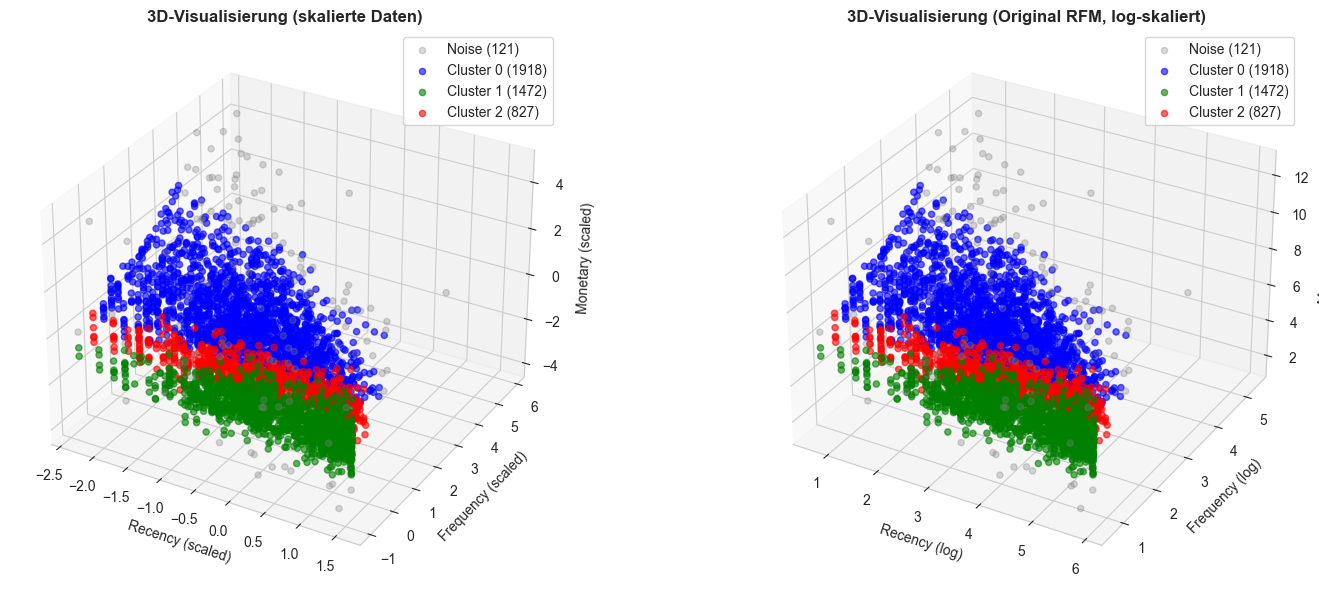


3D-Visualisierung erstellt!

CLUSTER-ANALYSE ABGESCHLOSSEN!

 ZUSAMMENFASSUNG:
   3 Kundensegmente identifiziert
   Jedes Segment hat ein eindeutiges RFM-Profil
   Klare Marketing-Empfehlungen pro Segment


In [59]:
print("=" * 70)
print("CLUSTER-ANALYSE & INTERPRETATION")
print("=" * 70)


# 1. ORIGINAL RFM-WERTE PRO CLUSTER

print("\n" + "=" * 70)
print("1. RFM-PROFILE DER CLUSTER")
print("=" * 70)

# rfm und rfm_scaled zusammenführen
rfm_final = rfm.copy()
rfm_final['Cluster'] = rfm_scaled['Cluster'].values

# Statistiken pro Cluster
cluster_profiles = rfm_final.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max']
}).round(2)

print("\nRFM-STATISTIKEN PRO CLUSTER:")
print(cluster_profiles)

# Durchschnittswerte für bessere Übersicht
print("\nDURCHSCHNITTSWERTE PRO CLUSTER:")
print("-" * 70)

for cluster in sorted(rfm_final['Cluster'].unique()):
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
    n_customers = len(cluster_data)
    
    avg_recency = cluster_data['Recency'].mean()
    avg_frequency = cluster_data['Frequency'].mean()
    avg_monetary = cluster_data['Monetary'].mean()
    
    if cluster == -1:
        print(f"\nNOISE ({n_customers} Kunden, {n_customers/len(rfm_final)*100:.1f}%):")
    else:
        print(f"\nCLUSTER {cluster} ({n_customers} Kunden, {n_customers/len(rfm_final)*100:.1f}%):")
    
    print(f"  - Recency:   {avg_recency:.0f} Tage (Median: {cluster_data['Recency'].median():.0f})")
    print(f"  - Frequency: {avg_frequency:.1f} Bestellungen (Median: {cluster_data['Frequency'].median():.0f})")
    print(f"  - Monetary:  £{avg_monetary:.2f} (Median: £{cluster_data['Monetary'].median():.2f})")


# 2. CLUSTER BENENNEN (BUSINESS INTERPRETATION)
print("\n" + "=" * 70)
print("2. CLUSTER-INTERPRETATION (KUNDENSEGMENTE)")
print("=" * 70)

# Durchschnittswerte berechnen
cluster_summary = rfm_final.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Anzahl'})

cluster_summary = cluster_summary[cluster_summary.index != -1]  # Noise ausschließen

print("\nCLUSTER-ÜBERSICHT:")
print(cluster_summary.round(2))

# Cluster interpretieren basierend auf RFM
print("\nCLUSTER-BEDEUTUNG:")
print("-" * 70)

for cluster in sorted(cluster_summary.index):
    data = cluster_summary.loc[cluster]
    
    r = data['Recency']
    f = data['Frequency']
    m = data['Monetary']
    
    print(f"\n- CLUSTER {cluster}:")
    
    # Interpretation basierend auf RFM-Werten
    if r < 50 and f > 4 and m > 1000:
        segment_name = "- CHAMPIONS (VIP-Kunden)"
        description = "Kaufen häufig, kürzlich und geben viel aus"
        action = "→ Belohnen, exklusive Angebote, persönliche Betreuung"
    elif r < 100 and f > 2 and m > 500:
        segment_name = "- LOYAL CUSTOMERS (Treue Kunden)"
        description = "Regelmäßige Käufer mit gutem Umsatz"
        action = "→ Loyalitätsprogramme, Cross-Selling, Upselling"
    elif r < 100 and f <= 2:
        segment_name = "- POTENTIAL LOYALISTS (Potenzielle Stammkunden)"
        description = "Noch nicht oft gekauft, aber kürzlich aktiv"
        action = "→ Engagement erhöhen, Angebote, Empfehlungen"
    elif r >= 100 and f > 2:
        segment_name = "- AT RISK (Gefährdete Kunden)"
        description = "Waren treu, aber lange nicht mehr da"
        action = "→ Rückgewinnungs-Kampagnen, Rabatte, Feedback einholen"
    elif r >= 100 and f <= 2:
        segment_name = "- HIBERNATING (Schlafende Kunden)"
        description = "Lange inaktiv, selten gekauft"
        action = "→ Reaktivierungs-E-Mails, besondere Angebote"
    else:
        segment_name = "- STANDARD CUSTOMERS (Standard-Kunden)"
        description = "Durchschnittliches Kaufverhalten"
        action = "-> Standard-Marketing, Newsletter"
    
    print(f"  {segment_name}")
    print(f"  {description}")
    print(f"  Anzahl: {int(data['Anzahl'])} Kunden")
    print(f"  Ø Recency: {r:.0f} Tage | Ø Frequency: {f:.1f} | Ø Monetary: £{m:.2f}")
    print(f"  {action}")

# Noise-Segment
noise_data = rfm_final[rfm_final['Cluster'] == -1]
if len(noise_data) > 0:
    print(f"\n NOISE (Ausreißer):")
    print(f" EXTREME CUSTOMERS (Extreme Kunden)")
    print(f"  Sehr ungewöhnliches Verhalten - Einzelfallanalyse nötig")
    print(f"  Anzahl: {len(noise_data)} Kunden ({len(noise_data)/len(rfm_final)*100:.1f}%)")
    print(f"  Ø Recency: {noise_data['Recency'].mean():.0f} Tage")
    print(f"  Ø Frequency: {noise_data['Frequency'].mean():.1f}")
    print(f"  Ø Monetary: £{noise_data['Monetary'].mean():.2f}")
    print(f"  → Manuelle Prüfung, möglicherweise B2B-Kunden oder Großhändler")


# 3. VISUALISIERUNG: 3D-SCATTER-PLOT

print("\n" + "=" * 70)
print("3. 3D-VISUALISIERUNG DER CLUSTER")
print("=" * 70)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# 3D-Plot (skalierte Daten)
ax1 = fig.add_subplot(121, projection='3d')

colors = ['blue', 'green', 'red', 'gray']
for cluster in sorted(rfm_scaled['Cluster'].unique()):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == cluster]
    
    if cluster == -1:
        label = f'Noise ({len(cluster_data)})'
        color = 'gray'
        alpha = 0.3
    else:
        label = f'Cluster {cluster} ({len(cluster_data)})'
        color = colors[cluster]
        alpha = 0.6
    
    ax1.scatter(
        cluster_data['Recency_scaled'],
        cluster_data['Frequency_scaled'],
        cluster_data['Monetary_scaled'],
        c=color, label=label, alpha=alpha, s=20
    )

ax1.set_xlabel('Recency (scaled)', fontsize=10)
ax1.set_ylabel('Frequency (scaled)', fontsize=10)
ax1.set_zlabel('Monetary (scaled)', fontsize=10)
ax1.set_title('3D-Visualisierung (skalierte Daten)', fontsize=12, fontweight='bold')
ax1.legend()

# 3D-Plot (Original RFM - Log-Skala)
ax2 = fig.add_subplot(122, projection='3d')

for cluster in sorted(rfm_final['Cluster'].unique()):
    cluster_data = rfm_final[rfm_final['Cluster'] == cluster]
    
    if cluster == -1:
        label = f'Noise ({len(cluster_data)})'
        color = 'gray'
        alpha = 0.3
    else:
        label = f'Cluster {cluster} ({len(cluster_data)})'
        color = colors[cluster]
        alpha = 0.6
    
    ax2.scatter(
        np.log1p(cluster_data['Recency']),
        np.log1p(cluster_data['Frequency']),
        np.log1p(cluster_data['Monetary']),
        c=color, label=label, alpha=alpha, s=20
    )

ax2.set_xlabel('Recency (log)', fontsize=10)
ax2.set_ylabel('Frequency (log)', fontsize=10)
ax2.set_zlabel('Monetary (log)', fontsize=10)
ax2.set_title('3D-Visualisierung (Original RFM, log-skaliert)', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n3D-Visualisierung erstellt!")


# 4. ZUSAMMENFASSUNG

print("\n" + "=" * 70)
print("CLUSTER-ANALYSE ABGESCHLOSSEN!")
print("=" * 70)

print("\n ZUSAMMENFASSUNG:")
print("   3 Kundensegmente identifiziert")
print("   Jedes Segment hat ein eindeutiges RFM-Profil")
print("   Klare Marketing-Empfehlungen pro Segment")
